# Url data

The data is stored in the file 'example.txt' in json format. Here's a couple of challenges proposed by the author. 

1. how many time zones are there in the dataset (try at least two methods). And find out top 10 time zones in this dataset. Plot them.
2. get percentage of windows users. and cross classify them with time zone information. Plot the aforemetioned cross sectional data.
3. Normalize 2. Which means instead of cout, we use percentage for each time zone.

## Q1 Most frequent time zone

In [29]:
#find the most frequent tz
import json
import pandas as pd 

json_file = [json.loads(line) for line in open('example.txt')] #list of dictionary
tz_list = [entry['tz'] for entry in json_file if 'tz' in entry]

#the pythonic solution will no pandas
from collections import defaultdict, Counter
count_tz = defaultdict(int)
for entry in tz_list:
    count_tz[entry] += 1
    
summary = Counter(count_tz)
summary.most_common(10)

[('America/New_York', 1251),
 ('', 521),
 ('America/Chicago', 400),
 ('America/Los_Angeles', 382),
 ('America/Denver', 191),
 ('Europe/London', 74),
 ('Asia/Tokyo', 37),
 ('Pacific/Honolulu', 36),
 ('Europe/Madrid', 35),
 ('America/Sao_Paulo', 33)]

In [42]:
dict_native = {} # solution 2 we got to do a membership check everytime,
#that's why default dict is preferred.
for entry in tz_list:
    if entry in dict_native:
        dict_native[entry] +=1 
    else:
        dict_native[entry] = 1

#reverse gives an iterator, need to materialize it by list keyword
top_10 = list(reversed(sorted([(v, k) for k, v in dict_native.items()])))[0:10]
top_10

[(1251, 'America/New_York'),
 (521, ''),
 (400, 'America/Chicago'),
 (382, 'America/Los_Angeles'),
 (191, 'America/Denver'),
 (74, 'Europe/London'),
 (37, 'Asia/Tokyo'),
 (36, 'Pacific/Honolulu'),
 (35, 'Europe/Madrid'),
 (33, 'America/Sao_Paulo')]

In [47]:
#one-liner solution from pandas
pd.Series(tz_list).value_counts(ascending=False)[0:10]

America/New_York       1251
                        521
America/Chicago         400
America/Los_Angeles     382
America/Denver          191
Europe/London            74
Asia/Tokyo               37
Pacific/Honolulu         36
Europe/Madrid            35
America/Sao_Paulo        33
dtype: int64

In [49]:
tz_clean = pd.Series(tz_list)
tz_clean = tz_clean.replace('', 'Empty String')
tz_clean = tz_clean.fillna('Missing')

In [60]:
table = tz_clean.value_counts()[0:10]
print(type(table))

<class 'pandas.core.series.Series'>


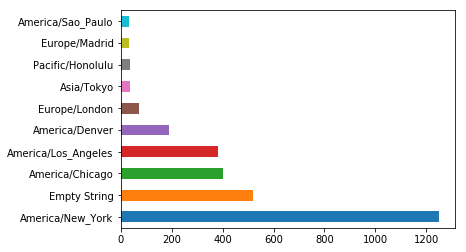

In [62]:
import matplotlib.pyplot as plt
figure, ax_ = plt.subplots(1)
table.plot.barh(ax=ax_)

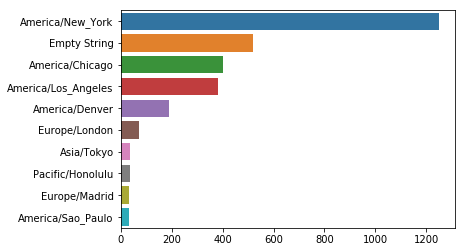

In [64]:
import seaborn as sns
sns.barplot(x=table.values, y=table.index)

## Q2 Operating System

If one needs to use groupby, we have to at least have key1, key2 and data. We can do it like that but I prefer the leanest solution. Hence only two categorical variables are kept and groupby does not work any more (no data column). Luckily, we still have crosstab function at our disposal. What cross tabs does is simply convert two categorical variables into a summary contingency table. 

In [85]:
#remove missing values
df_for_os = pd.DataFrame(json_file)
os_ = df_for_os[['tz', 'a']]
os_ = os_[os_.a.notnull()]
os_['tz'] = os_.tz.replace('', 'Empty String')
os_['tz'] = os_['tz'].fillna('Missing')

import numpy as np 
os_['a'] = np.where(os_.a.str.contains('Windows'), 'Windows', 'Not Windows')
os_by_tz = pd.crosstab(os_.a, os_.tz).T

The twist of this part is, we want to sort by the sum of windows and non windows computers. The solution is simply aggregate these two types first and sort it and keep the index. These indices are used to the filter the original dataframe so that qualified candidates are retained.

In [187]:
top_10_regions_index = os_by_tz.sum(1).sort_values(ascending=False)[0:10].index
top_10_regions_index_integer = os_by_tz.sum(1).argsort()[-10:]

a = os_by_tz.iloc[top_10_regions_index_integer]
b = os_by_tz.loc[top_10_regions_index]

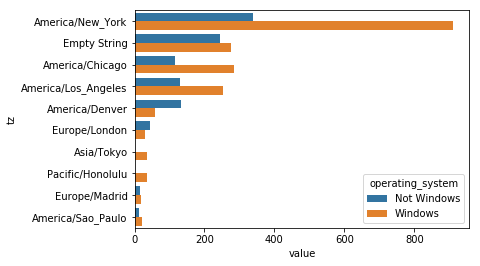

In [188]:
#these two methods are equalvalent. aims to flatten the dataframe into a  format
melted_ = b.stack().reset_index().rename({'a': 'operating_system', 0: 'count'}, axis=1)
melted_2 = b.reset_index().melt(id_vars='tz').rename({'a': 'operating_system', 0: 'count'}, axis=1)
sns.barplot(data=melted_2, y='tz', x='value', hue='operating_system')#an id, var, value is good for this kind of plot

# normalized version

The spirit is like stacked barchart, in which percent is more important than the count. Hence for each group (within NY time zone), we normalize the values by converting them into percentages.

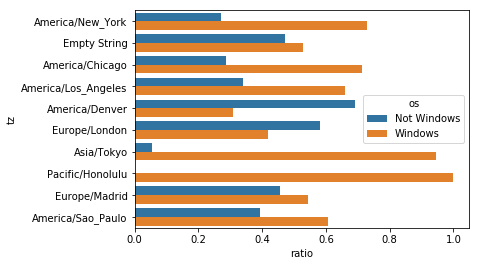

In [190]:
b['sum_'] = b.apply(sum, axis=1)
b['Not Windows'] = b['Not Windows']/b.sum_
b['Windows'] = b['Windows']/b.sum_

b.drop('sum_', axis=1, inplace=True)
b_melted = b.stack().reset_index()
b_melted = b_melted.rename({'a':'os', 0:'ratio'}, axis=1)
sns.barplot(data=b_melted, x='ratio', y='tz', hue='os')